# BUSINESS PROBLEM:
## Your task to build network intrusion detection system to detect anamolies and attacks in the network.
# ---------------------------------------------------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier



import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [3]:
#Writing output data into excel
output = pd.ExcelWriter('IDS_output.xlsx')

# UDF'S

In [4]:
#Function for getting statistical information of continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.99), x.max()], 
                  index = ['COUNT', 'MISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                                'P99' ,'MAX'])

In [5]:
#Function for getting statistical information of categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), len(np.unique(x)), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/x.count()), 2)], 
                      index = ['COUNT', 'UNIQUE', 'MISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
#Function for creating dummy variables
def dummy_var(df, col):
    dummies = pd.get_dummies(df[col], prefix = col, drop_first = True)
    df = pd.concat([df, dummies], axis = 1)
    df.drop(col, axis = 1, inplace = True )
    return df

In [7]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

# Importing File

In [8]:
#Column names
cols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

#Loading Train and Test Dataset
train = pd.read_table('Train.txt', sep = ',', names = cols).iloc[:,:-1]
test = pd.read_table('Test.txt', sep = ',', names = cols).iloc[:,:-1]

# Understanding the data

In [9]:
train.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [11]:
test.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.0,1.0,1.0,0.04,0.06,0.0,255,10,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.0,0.0,0.0,0.0,1.0,1.0,neptune


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 42 columns):
duration                       22544 non-null int64
protocol_type                  22544 non-null object
service                        22544 non-null object
flag                           22544 non-null object
src_bytes                      22544 non-null int64
dst_bytes                      22544 non-null int64
land                           22544 non-null int64
wrong_fragment                 22544 non-null int64
urgent                         22544 non-null int64
hot                            22544 non-null int64
num_failed_logins              22544 non-null int64
logged_in                      22544 non-null int64
num_compromised                22544 non-null int64
root_shell                     22544 non-null int64
su_attempted                   22544 non-null int64
num_root                       22544 non-null int64
num_file_creations             22544 non-null int64
num_

# Data Processing

In [13]:
#Changing column names
train.rename(columns = {'logged_in':'logged'}, inplace = True)
test.rename(columns = {'logged_in':'logged'}, inplace = True)

In [14]:
train.attack.value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

In [15]:
test.attack.value_counts()

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
phf                   2
loadmodule            2
sqlattack             2
udpstorm              2
perl                  2
imap                  1
Name: attack, dtype: int64

In [16]:
#Defining Attack Class
dos   = ('back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 
         'udpstorm', 'processtable', 'worm', 'mailbomb', 'processtable')
probe = ('satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint')
r2l   = ('guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient',
         'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 
         'sendmail', 'named')
u2r   = ('buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps')

### Monomial Classification

In [17]:
#Assigning Attack Class to train and test dataset
train['attack_class'] = np.where(train.attack.isin(dos), 'DoS',
                                 np.where(train.attack.isin(probe), 'Probe',
                                         np.where(train.attack.isin(r2l), 'R2L', 
                                                 np.where(train.attack.isin(u2r), 'U2R', 'Normal'))))

test['attack_class'] = np.where(test.attack.isin(dos), 'DoS',
                                 np.where(test.attack.isin(probe), 'Probe',
                                         np.where(test.attack.isin(r2l), 'R2L', 
                                                 np.where(test.attack.isin(u2r), 'U2R', 'Normal'))))

### Binomial Classification

In [18]:
#Assigning Activity Normal : 0 and Attack : 1 
train['activity'] = np.where(train['attack_class'].isin(['DoS', 'Probe', 'R2L', 'U2R']), 1, 0)
test['activity'] = np.where(test['attack_class'].isin(['DoS', 'Probe', 'R2L', 'U2R']), 1, 0)

In [19]:
#Attacks in train dataset
train.activity.value_counts()

0    67343
1    58630
Name: activity, dtype: int64

In [20]:
#Attacks in test dataset
test.activity.value_counts()

1    12833
0     9711
Name: activity, dtype: int64

In [21]:
#Frequency of different Attack Class for train dataset
train.attack_class.value_counts()

Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: attack_class, dtype: int64

In [22]:
#Frequency of different Attack Class for test dataset
test.attack_class.value_counts()

Normal    9711
DoS       7460
R2L       2885
Probe     2421
U2R         67
Name: attack_class, dtype: int64

In [23]:
#Dropping attack feature
train.drop('attack', axis = 1, inplace = True)
test.drop('attack', axis = 1, inplace = True)

In [24]:
#Getting Categorical and Continuous Features
cat_cols = set(['protocol_type', 'service', 'flag', 'activity', 'attack_class', 'land',
            'logged', 'root_shell','is_host_login', 'is_guest_login', 'su_attempted'])

cont_cols = train.columns.difference(cat_cols)

# EDA

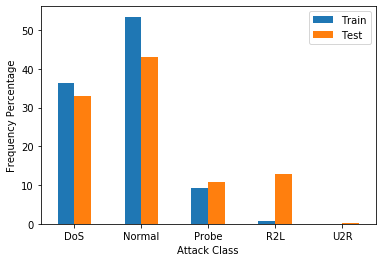

In [25]:
#Different Attack Classes percentage in train and test datasets
pd.concat([(train.attack_class.value_counts()/train.shape[0])*100,
           (test.attack_class.value_counts()/test.shape[0])*100], axis = 1).plot(kind = 'bar')
plt.legend(['Train','Test'])
plt.xlabel('Attack Class')
plt.xticks(rotation = 0)
plt.ylabel('Frequency Percentage')
plt.show()


Dos attacks are maximum and U2R attacks are minimum

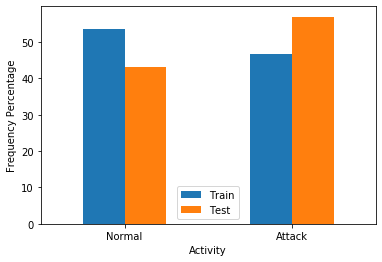

In [26]:
#Activity in train and test datasets
pd.concat([(train.activity.value_counts()/train.shape[0])*100,
           (test.activity.value_counts()/test.shape[0])*100], axis = 1).plot(kind = 'bar')
plt.legend(['Train','Test'])
plt.xlabel('Activity')
plt.xticks(ticks = (0,1), rotation = 0, labels = ('Normal', 'Attack'))
plt.ylabel('Frequency Percentage')
plt.show()

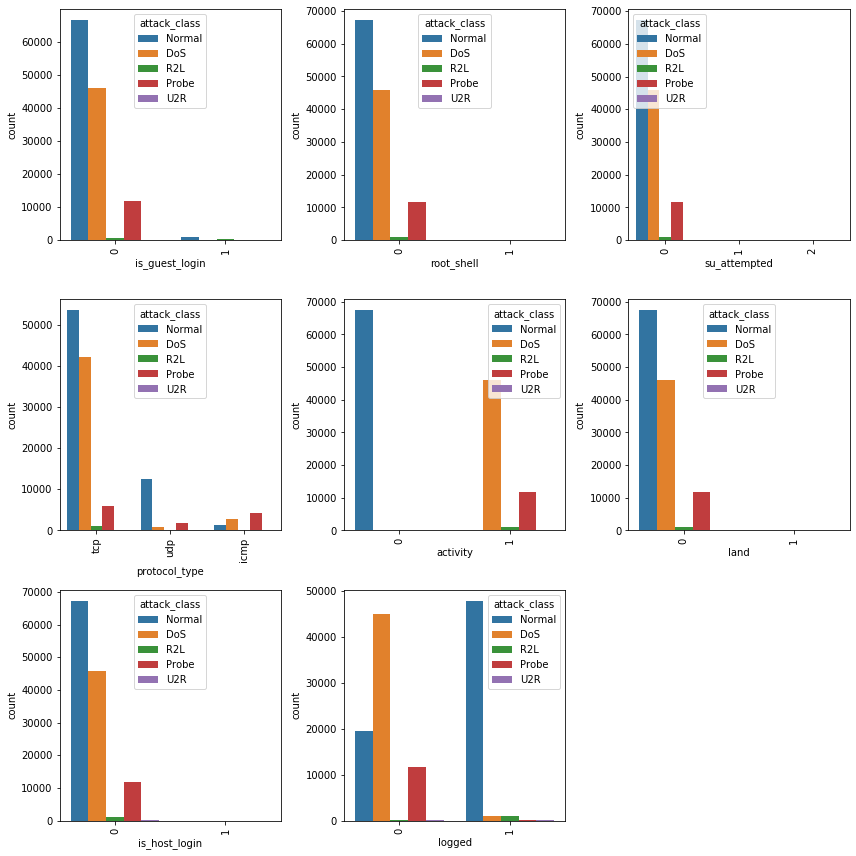

In [27]:
#Attack class across different categorical features
plt.figure(figsize = (12,12))
for a, b in enumerate(cat_cols.difference(['attack_class', 'service', 'flag'])):
    plt.subplot(3, 3, a+1)
    plt.subplots_adjust(hspace = 1)
    sns.countplot(x = b, data = train, hue = 'attack_class')
    plt.xticks(rotation = 90)
    plt.tight_layout()
plt.show()

#### Analysis:-
- root_shell =  the Dos attack is high when root_shell is not obtained.
- land = when source and destination IP addresses and port numbers are not equal then, Dos attack is higher
- is_host_login = Dos attcks are higher when the host is not logged in.
- protocol_type  = In TCP protocol , Dos Attacks are higher.
- is_guest_login = when the guest is not logged in the Dos attacks are high.
- activity = dos attacks are higher
- su_attempted = when suroot command is used, then Dos attcks are high


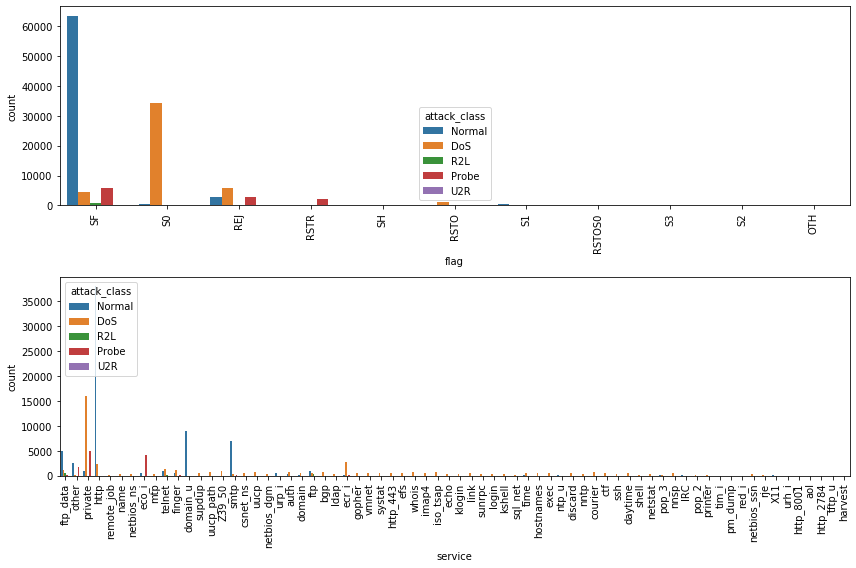

In [28]:
#Attack class across different service and flag
plt.figure(figsize = (12,8))
for a, b in enumerate(['flag', 'service']):
    plt.subplot(2, 1, a+1)
    plt.subplots_adjust(hspace = 1)
    sns.countplot(x = b, data = train, hue = 'attack_class')
    plt.xticks(rotation = 90)
    plt.tight_layout()
plt.show()

  attack_class     duration      src_bytes      dst_bytes      land  \
0          DoS     0.006227    1176.321162     169.201537  0.000392   
1       Normal   168.587396   13133.279331    4329.685223  0.000104   
2        Probe  2074.858185  385679.838367  181074.911805  0.000000   
3          R2L   633.417085  307727.300503   81822.026131  0.000000   
4          U2R    80.942308     906.230769    5141.961538  0.000000   

   wrong_fragment    urgent       hot  num_failed_logins    logged  \
0        0.062229  0.000000  0.039889           0.000000  0.020837   
1        0.000000  0.000148  0.230655           0.001381  0.710646   
2        0.000000  0.000000  0.001630           0.000343  0.007121   
3        0.000000  0.003015  8.334673           0.056281  0.913568   
4        0.000000  0.019231  1.403846           0.019231  0.884615   

   num_compromised  root_shell  su_attempted  num_root  num_file_creations  \
0         0.019226    0.000000      0.000000  0.000000            0.000000

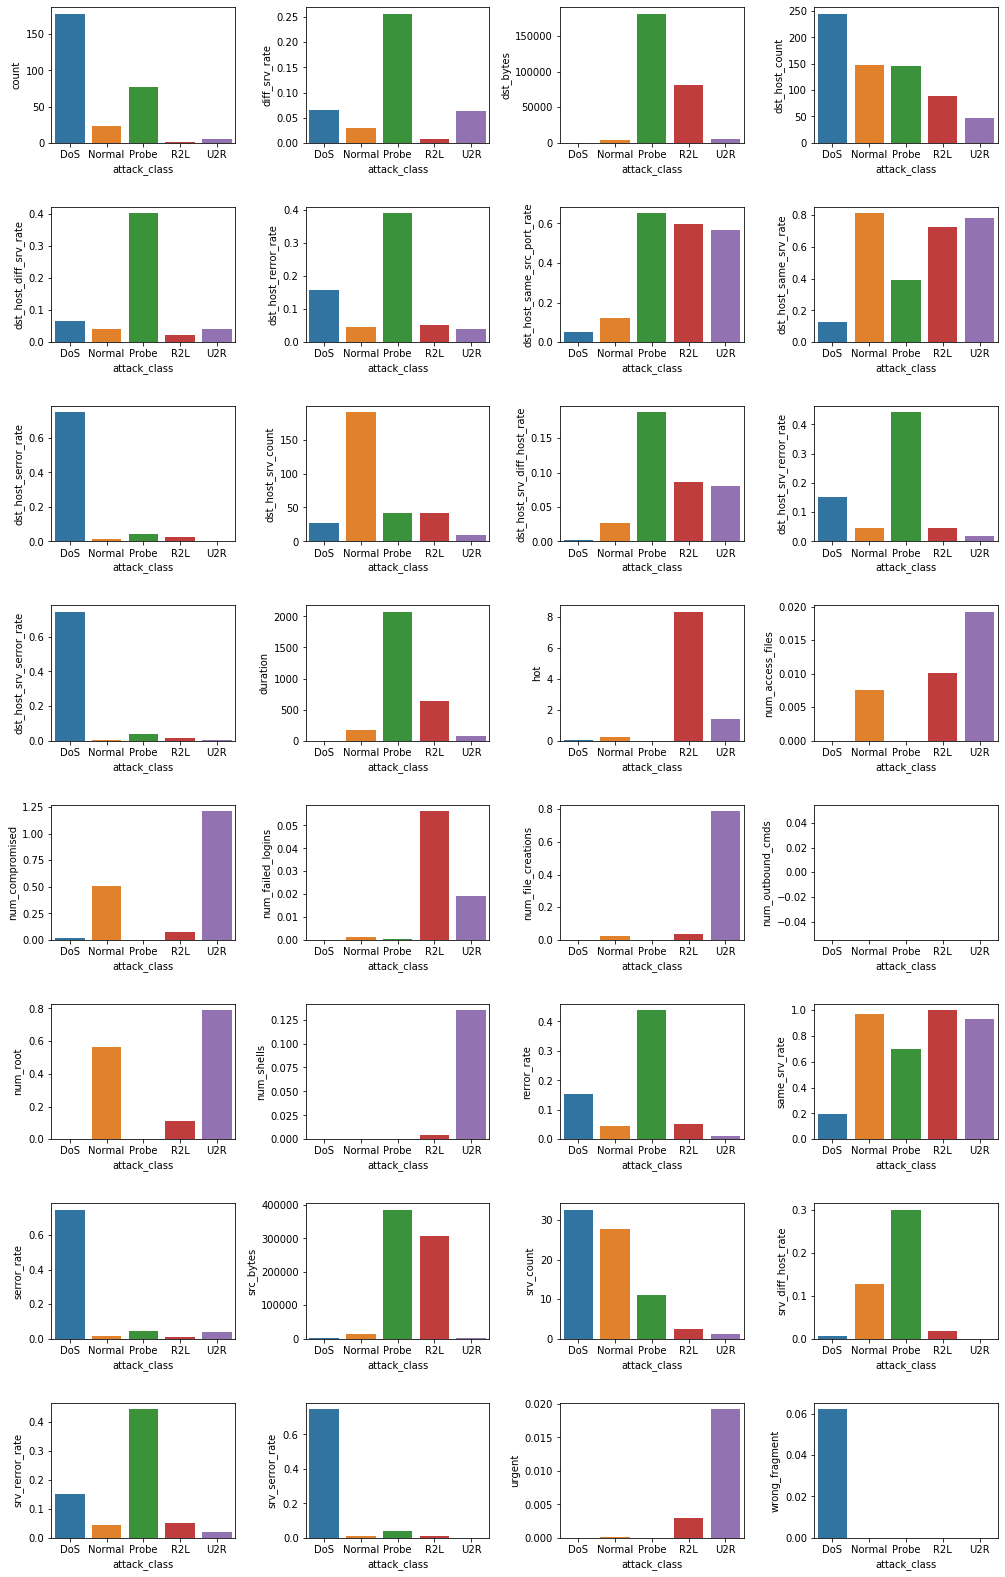

In [29]:
#Attack Classes across different continuous features
cont_plot = train.groupby('attack_class').mean().reset_index()
print(cont_plot)

plt.figure(figsize = (14,22))
for a, b in enumerate(cont_cols):
    plt.subplot(8, 4, a+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = 'attack_class', y = b, data = cont_plot)
    plt.tight_layout()
plt.show() 

#### Analysis:-
- Probing (Prob) is high in<br>
 diff_srv_rate, dst_bytes, dst_host_diff_srv_rate, dst_host_rerror rate, dst_host_srv_diff_host_rate, dst_host_srv_rerror        rate, duration, rerror_rate, src_bytes, srv_diff_host_rate, srv_rerror_rate, dst_host_same_src_port_rate
- Dos attacks are high in<br>
count,dst_host_count,dst_host_serror_rate,dst_host_srv_serror_rate,serror_rate,srv_count,srv_serror_rate,wrong_fragment
- R2L is high in<br>
hot,num_failed_logins,same_srv_rate
- U2R is high in<br>
num_access_files,num_compormised, num_file_creations,num_root,num_shells,urgent

# Summary


In [30]:
#Continuous Variable Summary 
cont_summary = train[cont_cols].apply(continuous_var_summary)
cont_summary.to_excel(output, 'Train Statistical Summary', startrow = 3)
cont_summary

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,dst_host_srv_serror_rate,duration,hot,num_access_files,num_compromised,num_failed_logins,num_file_creations,num_outbound_cmds,num_root,num_shells,rerror_rate,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,urgent,wrong_fragment
COUNT,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,125973.000000,125973.000000,125973.000000,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
MISS,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
SUM,1.059528e+07,7942.930000,2.491634e+09,2.294585e+07,10449.600000,14969.600000,18691.730000,65662.380000,35833.330000,1.456916e+07,4099.470000,15146.980000,35081.530000,3.617247e+07,25750.000000,516.000000,35178.000000,154.000000,1596.000000,0.0,38068.000000,52.000000,15111.530000,83259.040000,35837.370000,5.740179e+09,3.494225e+06,12259.900000,15265.820000,35585.530000,14.000000,2858.000000
MEAN,8.410755e+01,0.063053,1.977911e+04,1.821489e+02,0.082951,0.118832,0.148379,0.521242,0.284452,1.156530e+02,0.032542,0.120240,0.278485,2.871447e+02,0.204409,0.004096,0.279250,0.001222,0.012669,0.0,0.302192,0.000413,0.119958,0.660928,0.284485,4.556674e+04,2.773789e+01,0.097322,0.121183,0.282485,0.000111,0.022687
MEDIAN,1.400000e+01,0.000000,0.000000e+00,2.550000e+02,0.020000,0.000000,0.000000,0.510000,0.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,4.400000e+01,8.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
STD,1.145086e+02,0.180314,4.021269e+06,9.920621e+01,0.188922,0.306557,0.308997,0.448949,0.444784,1.107027e+02,0.112564,0.319459,0.445669,2.604515e+03,2.149968,0.099370,23.942042,0.045239,0.483935,0.0,24.399618,0.022181,0.320436,0.439623,0.446456,5.870331e+06,7.263584e+01,0.259830,0.323647,0.447022,0.014366,0.253530
VAR,1.311222e+04,0.032513,1.617061e+13,9.841873e+03,0.035691,0.093977,0.095479,0.201556,0.197833,1.225510e+04,0.012671,0.102054,0.198621,6.783500e+06,4.622364,0.009874,573.221387,0.002047,0.234193,0.0,595.341363,0.000492,0.102679,0.193268,0.199323,3.446079e+13,5.275965e+03,0.067512,0.104748,0.199829,0.000206,0.064277
MIN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
P1,1.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
P99,5.110000e+02,1.000000,2.551900e+04,2.550000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,2.550000e+02,0.520000,1.000000,1.000000,9.590560e+03,3.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,5.454000e+04,4.920000e+02,1.000000,1.000000,1.000000,0.000000,0.000000


In [31]:
#Categorical Variable Summary 
cat_summary = train[cat_cols].apply(categorical_var_summary)
cat_summary.to_excel(output, 'Train Statistical Summary', startrow = 17)
cat_summary

,is_guest_login,root_shell,su_attempted,protocol_type,activity,land,attack_class,service,is_host_login,flag,logged
COUNT,125973.00,125973.00,125973.00,125973,125973.00,125973.00,125973,125973,125973.0,125973,125973.00
UNIQUE,2.00,2.00,3.00,3,2.00,2.00,5,70,2.0,11,2.00
MISS,0.00,0.00,0.00,0,0.00,0.00,0,0,0.0,0,0.00
MODE,0.00,0.00,0.00,tcp,0.00,0.00,Normal,http,0.0,SF,0.00
FREQ,124786.00,125804.00,125893.00,102689,67343.00,125948.00,67343,40338,125972.0,74945,76121.00
PERCENT,99.06,99.87,99.94,81.52,53.46,99.98,53.46,32.02,100.0,59.49,60.43


In [32]:
#Continuous Variable Summary 
cont_summ_test = test[cont_cols].apply(continuous_var_summary)
cont_summ_test.to_excel(output, 'Test Statistical Summary', startrow = 3)
cont_summ_test

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,dst_host_srv_serror_rate,duration,hot,num_access_files,num_compromised,num_failed_logins,num_file_creations,num_outbound_cmds,num_root,num_shells,rerror_rate,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,urgent,wrong_fragment
COUNT,2.254400e+04,22544.000000,2.254400e+04,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,2.254400e+04,22544.000000,22544.000000,22544.000000,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.0,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
MISS,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SUM,1.781615e+06,2120.800000,4.635089e+07,4.370592e+06,2041.130000,5261.430000,2981.690000,13723.020000,2205.110000,3.173080e+06,442.730000,5110.340000,2241.460000,4.933959e+06,2376.000000,80.000000,2703.000000,488.000000,197.000000,0.0,2585.000000,26.000000,5375.910000,16690.330000,2320.310000,2.343550e+08,701668.000000,2211.800000,5301.870000,2336.350000,16.000000,190.000000
MEAN,7.902834e+01,0.094074,2.056019e+03,1.938694e+02,0.090540,0.233385,0.132261,0.608722,0.097814,1.407505e+02,0.019638,0.226683,0.099426,2.188591e+02,0.105394,0.003549,0.119899,0.021647,0.008738,0.0,0.114665,0.001153,0.238463,0.740345,0.102924,1.039545e+04,31.124379,0.098110,0.235179,0.103635,0.000710,0.008428
MEDIAN,8.000000e+00,0.000000,4.600000e+01,2.550000e+02,0.010000,0.000000,0.000000,0.920000,0.000000,1.680000e+02,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.400000e+01,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
STD,1.285392e+02,0.259138,2.121930e+04,9.403566e+01,0.220717,0.387229,0.306268,0.435688,0.273139,1.117840e+02,0.085394,0.400875,0.281866,1.407177e+03,0.928428,0.067829,7.269597,0.150328,0.676842,0.0,8.041614,0.048014,0.416118,0.412496,0.295367,4.727864e+05,89.062532,0.253545,0.416215,0.298332,0.036473,0.142599
VAR,1.652234e+04,0.067152,4.502586e+08,8.842706e+03,0.048716,0.149946,0.093800,0.189824,0.074605,1.249566e+04,0.007292,0.160701,0.079449,1.980146e+06,0.861979,0.004601,52.847044,0.022598,0.458115,0.0,64.667551,0.002305,0.173154,0.170153,0.087242,2.235270e+11,7932.134554,0.064285,0.173235,0.089002,0.001330,0.020334
MIN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P1,1.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P99,5.110000e+02,1.000000,2.603204e+04,2.550000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,2.550000e+02,0.405700,1.000000,1.000000,7.589570e+03,2.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,2.836180e+05,511.000000,1.000000,1.000000,1.000000,0.000000,0.000000


In [33]:
#Categorical Variable Summary 
cat_summ_test = test[cat_cols].apply(categorical_var_summary)
cat_summ_test.to_excel(output, 'Test Statistical Summary', startrow = 17)
cat_summ_test

,is_guest_login,root_shell,su_attempted,protocol_type,activity,land,attack_class,service,is_host_login,flag,logged
COUNT,22544.00,22544.00,22544.00,22544,22544.00,22544.00,22544,22544,22544.00,22544,22544.00
UNIQUE,2.00,2.00,3.00,3,2.00,2.00,5,64,2.00,11,2.00
MISS,0.00,0.00,0.00,0,0.00,0.00,0,0,0.00,0,0.00
MODE,0.00,0.00,0.00,tcp,1.00,0.00,Normal,http,0.00,SF,0.00
FREQ,21903.00,22489.00,22540.00,18880,12833.00,22537.00,9711,7853,22533.00,14875,12575.00
PERCENT,97.16,99.76,99.98,83.75,56.92,99.97,43.08,34.83,99.95,65.98,55.78


# Data Preparation

In [34]:
#Handling Ouliers in train and test dataset
train[cont_cols] = train[cont_cols].apply(outlier_capping)
train[cont_cols].to_excel(output, 'Train Oulier Treatment')

test[cont_cols] = test[cont_cols].apply(outlier_capping)
test[cont_cols].to_excel(output, 'Test Oulier Treatment')

In [35]:
#Columns containing all zeros
zero_cols = train.columns[(train==0).all()]
zero_cols

Index(['wrong_fragment', 'urgent', 'num_failed_logins', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds'],
      dtype='object')

In [36]:
#Dropping the column containing all zeros
train.drop(zero_cols, axis = 1, inplace = True)
test.drop(zero_cols, axis = 1, inplace = True)

#Dropping service Column as it contains high number of categories
train.drop('service', axis = 1, inplace = True)
test.drop('service', axis = 1, inplace = True)

#Updated Continuous and cateforical columns list
cont_cols = cont_cols.difference(zero_cols)
cat_cols = cat_cols.difference(zero_cols)

In [37]:
#Checking missing values in train dataset
train.isna().sum()

duration                       0
protocol_type                  0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
hot                            0
logged                         0
num_compromised                0
root_shell                     0
su_attempted                   0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_same_src_port_rate    0
dst_host_srv_diff_host_rate    0
dst_host_serror_rate           0
dst_host_srv_serror_rate       0
dst_host_r

In [38]:
#Checking missing values in test dataset
test.isna().sum()

duration                       0
protocol_type                  0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
hot                            0
logged                         0
num_compromised                0
root_shell                     0
su_attempted                   0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_same_src_port_rate    0
dst_host_srv_diff_host_rate    0
dst_host_serror_rate           0
dst_host_srv_serror_rate       0
dst_host_r

### Creating Dummy Variables

In [39]:
#Creating Dummy Variables for nominal features
for col in ('protocol_type', 'flag'):
    train = dummy_var(train, col)
    test  = dummy_var(test, col)

In [40]:
#Encoding target variable 'attack_class' using Label Encoder
target_map = {'Normal':'0', 'DoS':'1', 'Probe':'2', 'R2L':'3', 'U2R':'4'}
train['attack_class'] = train['attack_class'].apply(lambda x: target_map[x])
test['attack_class'] = test['attack_class'].apply(lambda x: target_map[x])

train['attack_class'] = train['attack_class'].astype('int64')
test['attack_class'] = test['attack_class'].astype('int64')

In [41]:
#Saving data to excel
train.to_excel(output, 'Encoded Train Data')
test.to_excel(output, 'Encoded Test Data')

### Sacaling numerical variables

In [42]:
#Standardizing the datasets
scaler = StandardScaler()
train[cont_cols] = pd.DataFrame(scaler.fit_transform(train[cont_cols]), columns = cont_cols)
test[cont_cols] = pd.DataFrame(scaler.transform(test[cont_cols]), columns = cont_cols)

train[cont_cols].head()

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,dst_host_srv_serror_rate,duration,hot,num_compromised,rerror_rate,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate
0,-0.717047,-0.349683,-0.352792,-0.324063,-0.280282,-0.224532,0.069972,-0.782367,-0.639532,-0.818890,-0.320917,-0.376387,-0.624871,-0.138442,-0.140747,-0.101557,-0.374362,0.771283,-0.637209,-0.087734,-0.357788,-0.374560,-0.374432,-0.631929
1,-0.620984,0.482201,-0.352792,0.734343,2.736852,-0.387635,2.367737,-1.161030,-0.639532,-1.035688,-0.320917,-0.376387,-0.624871,-0.138442,-0.140747,-0.101557,-0.374362,-1.321428,-0.637209,-0.143942,-0.371789,-0.374560,-0.374432,-0.631929
2,0.339647,0.038529,-0.352792,0.734343,-0.174417,-0.387635,-0.480197,-0.938287,1.608759,-0.809857,-0.320917,-0.376387,1.618955,-0.138442,-0.140747,-0.101557,-0.374362,-1.389669,1.602664,-0.167729,-0.301781,-0.374560,-0.374432,1.605104
3,-0.690848,-0.349683,1.790321,-1.533670,-0.439078,-0.387635,-0.383108,1.066401,-0.572083,1.258754,0.112042,-0.345084,-0.602433,-0.138442,-0.140747,-0.101557,-0.374362,0.771283,-0.189235,-0.129931,-0.315783,-0.374560,-0.374432,-0.184522
4,-0.472523,-0.349683,-0.242390,0.734343,-0.439078,-0.387635,-0.480197,1.066401,-0.639532,1.258754,-0.320917,-0.376387,-0.624871,-0.138442,-0.140747,-0.101557,-0.374362,0.771283,-0.637209,-0.135307,0.062263,-0.028179,-0.374432,-0.631929


In [43]:
#Saving scaled data to excel
train[cont_cols].to_excel(output, 'Scaled Train Data')
test[cont_cols].to_excel(output, 'Scaled Test Data')

### Correlation Matrix

In [44]:
#Checking correlation with the dependant variable - 'activity'
corr_activity = train.corrwith(train['activity']).sort_values(ascending = False)
corr_activity.to_excel(output, 'Correlation with Target', startcol = 2)
corr_activity

activity                       1.000000
attack_class                   0.887801
dst_host_srv_serror_rate       0.654985
dst_host_serror_rate           0.651842
serror_rate                    0.650652
flag_S0                        0.650206
srv_serror_rate                0.648289
count                          0.576444
dst_host_count                 0.375052
srv_rerror_rate                0.253504
dst_host_srv_rerror_rate       0.253430
rerror_rate                    0.253397
dst_host_rerror_rate           0.252563
dst_host_diff_srv_rate         0.242898
diff_srv_rate                  0.203660
flag_REJ                       0.184949
flag_RSTR                      0.133099
dst_host_same_src_port_rate    0.092444
flag_RSTO                      0.088592
dst_host_srv_diff_host_rate    0.055120
protocol_type_tcp              0.053126
num_compromised                0.049946
flag_SH                        0.049075
flag_RSTOS0                    0.030658
duration                       0.009284


In [45]:
#Checking correlation with the dependant variable - 'attack_class'
corr_attack = train.corrwith(train['attack_class']).sort_values(ascending = False)
corr_attack.to_excel(output, 'Correlation with Target', startcol = 5)
corr_attack

attack_class                   1.000000
activity                       0.887801
dst_host_diff_srv_rate         0.391328
count                          0.388358
dst_host_srv_serror_rate       0.384796
dst_host_serror_rate           0.382118
serror_rate                    0.381646
srv_serror_rate                0.378669
flag_S0                        0.373549
dst_host_same_src_port_rate    0.319096
dst_host_srv_rerror_rate       0.310227
srv_rerror_rate                0.309909
rerror_rate                    0.308668
dst_host_rerror_rate           0.293805
diff_srv_rate                  0.282314
flag_RSTR                      0.255984
dst_host_srv_diff_host_rate    0.246424
flag_REJ                       0.198654
dst_host_count                 0.196102
flag_SH                        0.095326
duration                       0.090309
flag_RSTO                      0.064064
hot                            0.063332
flag_RSTOS0                    0.058729
is_guest_login                 0.030600


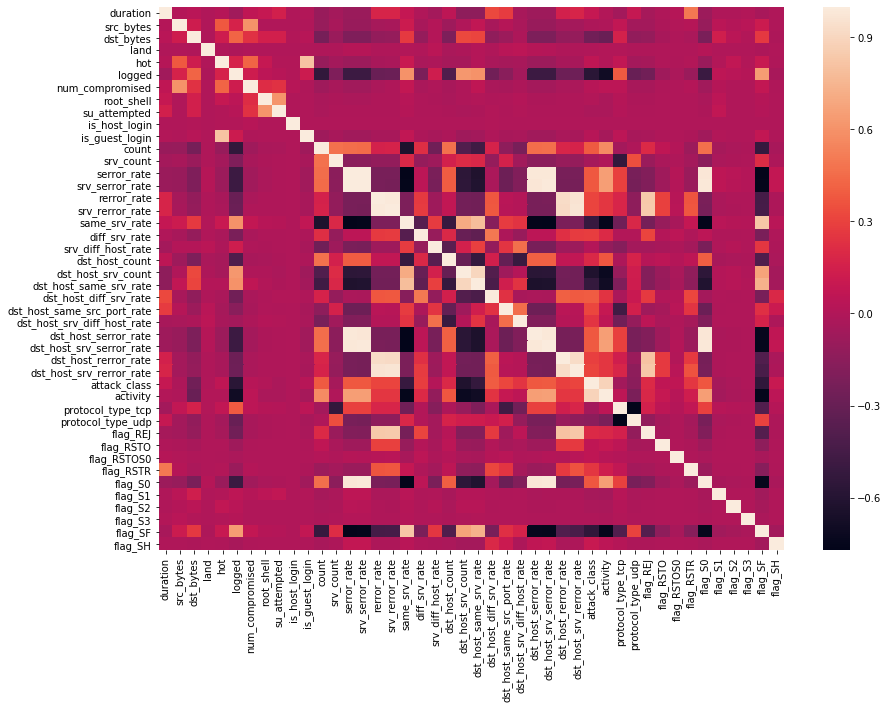

In [46]:
#Correlation Matrix for train dataset
cm = train.corr()
cm.to_excel(output, 'Train Correlation Matrix')

plt.figure(figsize = (14,10))
sns.heatmap(cm)
plt.show()

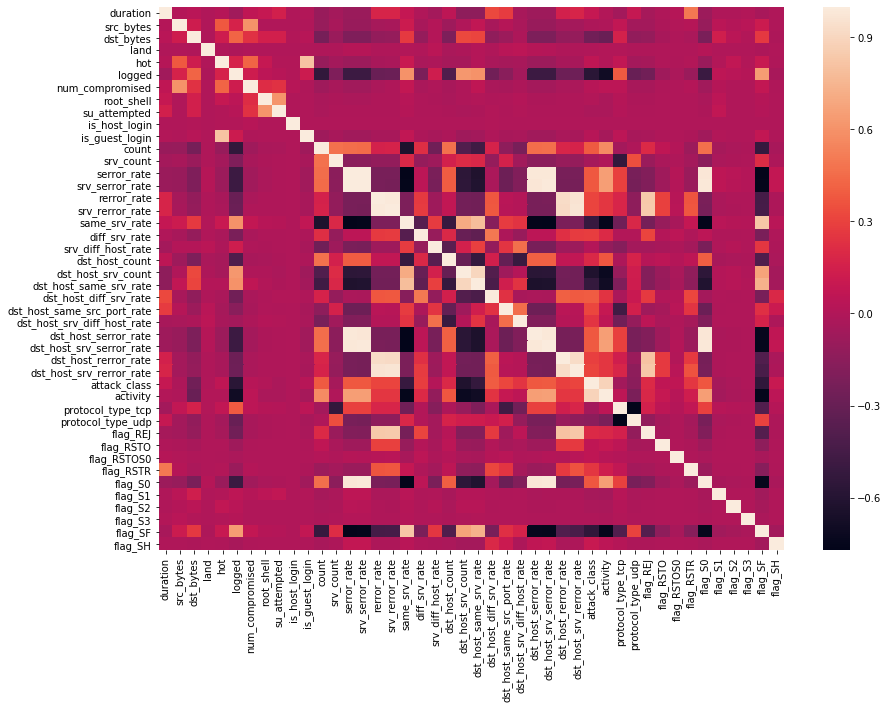

In [47]:
#Correlation Matrix for test dataset
cm1 = train.corr()
cm1.to_excel(output, 'Test Correlation Matrix')

plt.figure(figsize = (14,10))
sns.heatmap(cm1)
plt.show()

# Feature Selection

In [48]:
#Using RandomForestClassifier as an estimator
est = ExtraTreeClassifier(random_state = 123)

feat_cols = train.columns.difference(['activity','attack_class'])

#Using RFE to get importance of each variable
rfe = RFE(estimator = est, n_features_to_select = 15)
rfe.fit(train[feat_cols], train['attack_class'])

#Getting important features
rfe_cols = feat_cols[rfe.support_]

pd.Series(rfe_cols).to_excel(output, 'RFE Result', index = True)

rfe_cols

Index(['count', 'dst_host_count', 'dst_host_diff_srv_rate',
       'dst_host_rerror_rate', 'dst_host_same_src_port_rate',
       'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count',
       'dst_host_srv_diff_host_rate', 'hot', 'logged', 'protocol_type_tcp',
       'same_srv_rate', 'src_bytes', 'srv_count'],
      dtype='object')

In [49]:
#Getting model formula
model_fm = '''attack_class ~ count + dst_host_count + dst_host_diff_srv_rate +
              dst_host_rerror_rate + dst_host_same_src_port_rate + dst_host_srv_count +
              dst_host_srv_diff_host_rate + hot + logged + protocol_type_tcp + src_bytes +
              srv_count'''

In [50]:
## Separating the X and Y variables
target_y, predictor_x  = dmatrices(model_fm, data = train, return_type = 'dataframe')

#Calculating VIF for each X and saving in DataFrame
vif = pd.DataFrame()
vif['Features'] = predictor_x.columns
vif['VIF Factor'] = [variance_inflation_factor(predictor_x.values, i) for i in range(predictor_x.shape[1])]

vif.round(1).to_excel(output, 'VIF Result', index = True)

#Getting features
vif_cols = list(set(vif.Features).difference(['Intercept']))

#VIF output
vif.round(1)

,Features,VIF Factor
0,Intercept,10.3
1,count,2.9
2,dst_host_count,2.0
3,dst_host_diff_srv_rate,1.5
4,dst_host_rerror_rate,1.4
5,dst_host_same_src_port_rate,1.9
6,dst_host_srv_count,2.9
7,dst_host_srv_diff_host_rate,1.7
8,hot,1.2
9,logged,3.8


# Prediction Model  
## Binomial Classification
### Predicting Activity - Normal or Attack

In [51]:
#Getting final features and target
X = vif_cols

#target for activity classification
Y1 = 'activity'

#Splitting Data into 70% train and 30% test
train_x, test_x, train_y, test_y = train_test_split(train[X], train[Y1], 
                                                    test_size = 0.3, 
                                                    random_state = 123)

### Decision Tree Model


In [52]:
#Using GridSearchCV to get best fit parameters
pm = {
           'max_features' : [10],
            'max_depth'   : [11]    
     }

gscv_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

In [53]:
gscv_dt.best_params_

{'max_depth': 11, 'max_features': 10}

In [54]:
#Using best fit parameters to fit the model
dt = gscv_dt.best_estimator_

#Making prediction on train and test data
train_pred_dt = dt.predict(train_x)
test_pred_dt = dt.predict(test_x)

#Calculating log loss
log_dt = metrics.log_loss(test_y, dt.predict_proba(test_x))

In [55]:
#Evaluating performance

print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_dt))
print("AUC      : ", metrics.roc_auc_score(train_y, dt.predict_proba(train_x)[:,1]))
print("")
print("Test Dataset")
acc_score_dt = metrics.accuracy_score(test_y, test_pred_dt)
print("Accuracy : ", acc_score_dt)
auc_dt = metrics.roc_auc_score(test_y, dt.predict_proba(test_x)[:,1])
print("AUC      : ", auc_dt)
print("Log Loss : ", log_dt)

Train Dataset
Accuracy :  0.9979247230128939
AUC      :  0.9999415608081177

Test Dataset
Accuracy :  0.9964278154106689
AUC      :  0.9984033694628809
Log Loss :  0.053043005732949414


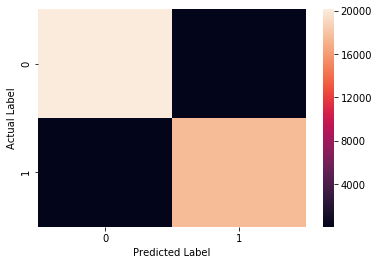

In [56]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_dt, labels = [0,1])
sns.heatmap(confusion_matrix)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [57]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20162
           1       1.00      0.99      1.00     17630

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



<BarContainer object of 12 artists>

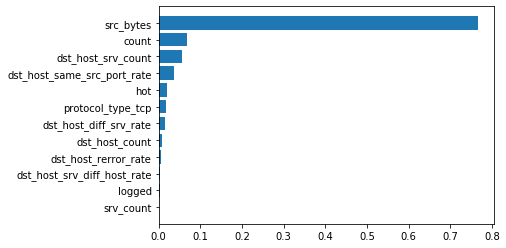

In [58]:
#Feature Impotance for Decision Tree Model
dt_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : dt.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

dt_fi.to_excel(output, 'Drivers_Binomial', startrow=30, startcol=1, index = False)

plt.barh(width = dt_fi.Importance, y = dt_fi.Features)

## KNN Model

In [59]:
# re-building the model for the best n_neighbors
knn_clf = KNeighborsClassifier( n_neighbors = 13 )
knn_clf.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=13)

In [60]:

#Making prediction on train and test data
train_pred_knn_clf = knn_clf.predict(train_x)
test_pred_knn_clf = knn_clf.predict(test_x)

#Calculating log loss
log_knn_clf = metrics.log_loss(test_y, knn_clf.predict_proba(test_x))

In [61]:
# get the model accuracy
print("Model Performance")
print("Accuracy Train Dataset : ", metrics.accuracy_score(train_y, knn_clf.predict(train_x)))
print("Accuracy Test Dataset  : ", metrics.accuracy_score(test_y, knn_clf.predict(test_x)))
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(train_x))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(test_x))[1]
# get the model auc
print("AUC Train Dataset      : ",metrics.roc_auc_score(train_y, train_predict_prob))
print("AUC Test Dataset       : ",metrics.roc_auc_score(test_y, test_predict_prob))
print("Log Loss : ", log_knn_clf )

Model Performance
Accuracy Train Dataset :  0.9921411641963689
Accuracy Test Dataset  :  0.9904477138018628
AUC Train Dataset      :  0.9998040535126531
AUC Test Dataset       :  0.9992269578974121
Log Loss :  0.036367643141252654


In [62]:
acc_score_knn_clf = metrics.accuracy_score(test_y, knn_clf.predict(test_x))
auc_knn_clf = metrics.roc_auc_score(test_y, test_predict_prob)                                           

In [63]:
# confusion matrix
knn_cm = metrics.confusion_matrix( test_y, knn_clf.predict( test_x ))[::-1, ::-1]

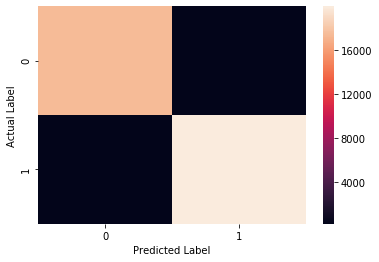

In [64]:
sns.heatmap(knn_cm)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [65]:

# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(test_y, knn_clf.predict( test_x )))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20162
           1       0.99      0.99      0.99     17630

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792



## XG Boost Model

In [66]:
#Using GridSearchCV to get best fit parameters
pm = {
          'n_estimators' : [100],
          'learning_rate': [0.1]
     }

gscv_xg = GridSearchCV(estimator = XGBClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

[12:27:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
#Using best fit parameters to fit the model
xg = gscv_xg.best_estimator_

#Making prediction on train and test data
train_pred_xg = xg.predict(train_x)
test_pred_xg = xg.predict(test_x)

#Calculating log loss
log_xg = metrics.log_loss(test_y, xg.predict_proba(test_x))

In [68]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_xg))
print("AUC      : ", metrics.roc_auc_score(train_y, xg.predict_proba(train_x)[:,1]))
print("")
print("Test Dataset")
acc_score_xg = metrics.accuracy_score(test_y, test_pred_xg)
print("Accuracy : ", acc_score_xg)
auc_xg = metrics.roc_auc_score(test_y, xg.predict_proba(test_x)[:,1])
print("AUC      : ", auc_xg)
print("Log Loss : ", log_xg)

Model Performance
Train Dataset
Accuracy :  0.9982762726664475
AUC      :  0.9999846044371934

Test Dataset
Accuracy :  0.9971687129551228
AUC      :  0.9999499122338779
Log Loss :  0.009022826069692865


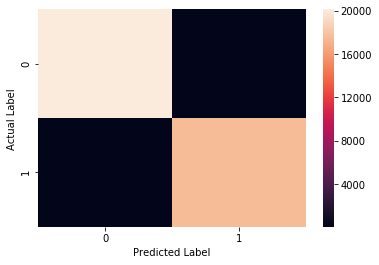

In [69]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_xg, labels = [0,1])
sns.heatmap(confusion_matrix )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [70]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_xg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20162
           1       1.00      1.00      1.00     17630

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



<BarContainer object of 12 artists>

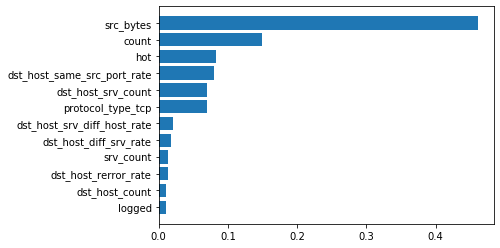

In [71]:
#Feature Impotance for XG Boost Model
xg_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : xg.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

xg_fi.to_excel(output, 'Drivers_Binomial', startrow=16, startcol=1, index = False)

plt.barh(width = xg_fi.Importance, y = xg_fi.Features)

### Comparing all models

In [72]:
#Getting accuracy and log loss for each model
metric_data = pd.DataFrame({'Classifiers' : [ 'DecisionTreeClassifier','KNNclassifier','XGBClassifier'],
                        'Accuracy %' : [acc_score_dt,acc_score_knn_clf,acc_score_xg],
                        'ROC_AUC_Score %' : [ auc_dt,auc_knn_clf ,auc_xg],    
                        'Log_Loss' : [log_dt,log_knn_clf,log_xg]})

In [73]:
metric_data[['Accuracy %','ROC_AUC_Score %']] = metric_data[['Accuracy %', 'ROC_AUC_Score %']].applymap(lambda x : round((x*100),2))

In [74]:
metric_data.to_excel(output, 'Binomial Metric Data')
metric_data

,Classifiers,Accuracy %,ROC_AUC_Score %,Log_Loss
0,DecisionTreeClassifier,99.64,99.84,0.053043
1,KNNclassifier,99.04,99.92,0.036368
2,XGBClassifier,99.72,99.99,0.009023


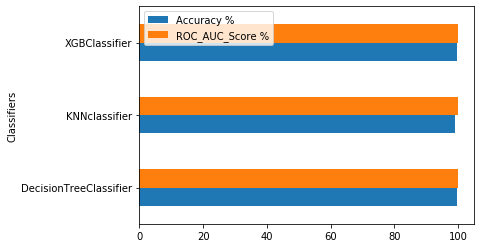

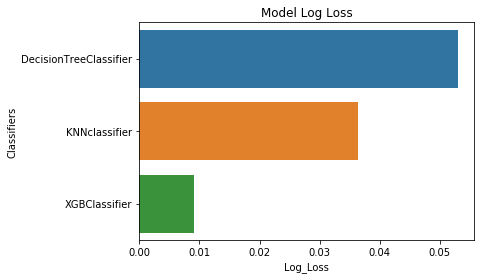

In [75]:
#Visualizing each model's accuracy and log loss metric
metric_data.plot(x = 'Classifiers', y = ['Accuracy %','ROC_AUC_Score %'], kind = 'barh')
plt.legend(loc = 2)
plt.show()

sns.barplot(data = metric_data, x = metric_data['Log_Loss'], y = metric_data.Classifiers)
plt.title('Model Log Loss')
plt.show()

### Final Prediction

In [76]:
#Making final predictions on provided test dataset
test_final = test[X]
test_final['activity'] = test['activity']
test_final['dt_activity'] = dt.predict(test_final[X])
test_final['Knn_activity'] = knn_clf.predict(test_final[X])
test_final['xg_activity'] = xg.predict(test_final[X])


test_final.to_excel(output, 'Final Predictions')

#Final Predictions
test_final.head()

,dst_host_srv_diff_host_rate,src_bytes,dst_host_count,dst_host_same_src_port_rate,dst_host_diff_srv_rate,count,hot,protocol_type_tcp,srv_count,dst_host_rerror_rate,dst_host_srv_count,logged,activity,dt_activity,Knn_activity,xg_activity
0,-0.320917,-0.167729,0.734343,-0.480197,-0.121485,1.265346,-0.140747,1,-0.245774,2.874410,-0.954389,0,1,1,1,1
1,-0.320917,-0.167729,0.734343,-0.480197,-0.121485,0.453176,-0.140747,1,-0.371789,2.874410,-1.035688,0,1,1,1,1
2,-0.104438,1.947498,-0.485344,1.493939,-0.227350,-0.725780,-0.140747,1,-0.371789,-0.387635,-0.267863,0,0,0,0,0
3,2.709796,-0.164470,-1.805832,2.756092,-0.439078,-0.725780,-0.140747,0,0.524319,-0.387635,-0.529827,0,1,0,1,1
4,-0.104438,-0.167729,-1.543751,-0.383108,0.460769,-0.725780,-0.140747,1,-0.273777,2.319862,-0.267863,0,1,0,0,0


In [77]:
#Accuracy of prediction on provided test dataset
test_acc_dt = metrics.accuracy_score(test_final['activity'], test_final['dt_activity'])
test_acc_knn = metrics.accuracy_score(test_final['activity'], test_final['Knn_activity'])
test_acc_xg = metrics.accuracy_score(test_final['activity'], test_final['xg_activity'])


test_auc_dt = metrics.roc_auc_score(test_final['activity'], dt.predict_proba(test_final[X])[:,1])
test_auc_knn = metrics.roc_auc_score(test_final['activity'], knn_clf.predict_proba(test_final[X])[:,1])
test_auc_xg = metrics.roc_auc_score(test_final['activity'], xg.predict_proba(test_final[X])[:,1])


test_metric = pd.DataFrame({'Classifiers' : [ 'DecisionTreeClassifier','KNNclassifier' ,'XGBClassifier' ],
                        'Accuracy %' : [test_acc_dt,test_acc_knn, test_acc_xg ],
                        'ROC_AUC_Score %' : [test_auc_dt,test_auc_xg , test_auc_xg],    
                        })

In [78]:
test_metric[['Accuracy %','ROC_AUC_Score %']] = test_metric[['Accuracy %', 'ROC_AUC_Score %']].applymap(lambda x : round((x*100),3))
test_metric

,Classifiers,Accuracy %,ROC_AUC_Score %
0,DecisionTreeClassifier,77.085,83.256
1,KNNclassifier,74.987,94.973
2,XGBClassifier,78.269,94.973


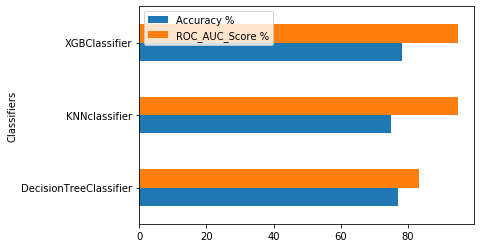

In [79]:
test_metric.plot(x = 'Classifiers', y = ['Accuracy %','ROC_AUC_Score %'], kind = 'barh')
plt.legend(loc = 2)
plt.show()

# Predictive Model 
## Multinomial Classification
### Attack type prediction



### Getting Train and Test Datasets

In [80]:
#Getting final features and target
X = vif_cols

#target for attack type classification
Y2 = 'attack_class'

#Splitting Data into 70% train and 30% test
train_x, test_x, train_y, test_y = train_test_split(train[X], train[Y2], 
                                                    test_size = 0.3, 
                                                    random_state = 123)

#### Data Sampling

In [87]:
#Using RandomOverSampler for rebalancing the data 
print('Original dataset shape {}'.format(Counter(train_y)))
ros = RandomOverSampler(random_state = 123, sampling_strategy = 'auto')
########################Resample#############################################
samp = ros
train_x, train_y = samp.fit_resample(train_x, train_y)

print('Oversampled dataset shape {}'.format(Counter(train_y)))

Original dataset shape Counter({0: 47181, 1: 32066, 2: 8194, 3: 700, 4: 40})
Oversampled dataset shape Counter({1: 47181, 0: 47181, 2: 47181, 3: 47181, 4: 47181})


### Decision Tree Model

In [88]:
#Using GridSearchCV to get best fit parameters
pm = {
           'max_features' : [10],
            'max_depth'   : [11]    
     }

gscv_dt2 = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

In [89]:
#Using best fit parameters to fit the model
dt2 = gscv_dt2.best_estimator_

#Making prediction on train and test data
train_pred_dt2 = dt2.predict(train_x)
test_pred_dt2 = dt2.predict(test_x)

#Calculating log loss
log_dt2 = metrics.log_loss(test_y, dt2.predict_proba(test_x))

In [90]:
### Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_dt2))
print("AUC      : ", metrics.roc_auc_score(train_y, dt2.predict_proba(train_x), multi_class = 'ovr'))
print("")
print("Test Dataset")
acc_score_dt2 = metrics.accuracy_score(test_y, test_pred_dt2)
print("Accuracy : ", acc_score_dt2)
auc_dt2 = metrics.roc_auc_score(test_y, dt2.predict_proba(test_x), multi_class = 'ovr')
print("AUC      : ", auc_dt2)
print("Log Loss : ", log_dt2)

Model Performance
Train Dataset
Accuracy :  0.996824993111634
AUC      :  0.9999008207267395

Test Dataset
Accuracy :  0.9919824301439458
AUC      :  0.9514727712286069
Log Loss :  0.10268400953039944


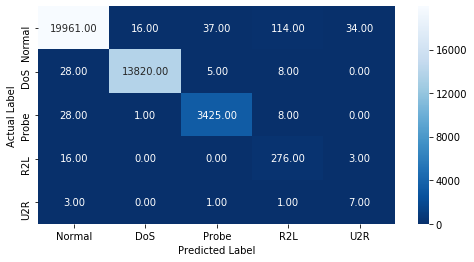

In [91]:
#Confusion Matrix
plt.figure(figsize = (8,4))
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_dt2, labels = [0,1,2,3,4])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'],
            yticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'],
            cmap = 'Blues_r'    
           )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [92]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_dt2))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20162
           1       1.00      1.00      1.00     13861
           2       0.99      0.99      0.99      3462
           3       0.68      0.94      0.79       295
           4       0.16      0.58      0.25        12

    accuracy                           0.99     37792
   macro avg       0.76      0.90      0.80     37792
weighted avg       0.99      0.99      0.99     37792



<BarContainer object of 12 artists>

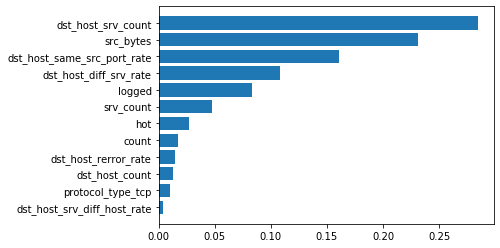

In [93]:
#Feature Impotance for Random Forest Model
dt2_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : dt2.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

dt2_fi.to_excel(output, 'Drivers_Multinomial', startrow=30, startcol=1, index = False)

plt.barh(width = dt2_fi.Importance, y = dt2_fi.Features)

# KNN Model

In [94]:
# re-building the model for the best n_neighbors
knn_clf2 = KNeighborsClassifier( n_neighbors = 13 )
knn_clf2.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=13)

In [95]:
#Making prediction on train and test data
train_pred_knn_clf2 = knn_clf2.predict(train_x)
test_pred_knn_clf2 = knn_clf2.predict(test_x)

#Calculating log loss
log_knn_clf2 = metrics.log_loss(test_y, knn_clf2.predict_proba(test_x))

In [96]:
# get the model accuracy
print("Model Performance")
print("Accuracy Train Dataset : ", metrics.accuracy_score(train_y, knn_clf2.predict(train_x)))
print("Accuracy Test Dataset  : ", metrics.accuracy_score(test_y, knn_clf2.predict(test_x)))
# get the probability score on training and testing
train_predict_prob2 = pd.DataFrame(knn_clf2.predict_proba(train_x))
test_predict_prob2 = pd.DataFrame(knn_clf2.predict_proba(test_x))
# get the model auc
print("AUC Train Dataset      : ",metrics.roc_auc_score(train_y, train_predict_prob2, multi_class = 'ovr'))
print("AUC Test Dataset       : ",metrics.roc_auc_score(test_y, test_predict_prob2, multi_class = 'ovr'))
print("Log Loss : ", log_knn_clf2 )

Model Performance
Accuracy Train Dataset :  0.9955575337529938
Accuracy Test Dataset  :  0.986637383573243
AUC Train Dataset      :  0.9999852664820098
AUC Test Dataset       :  0.9549977199067243
Log Loss :  0.09529724331559876


In [97]:
acc_score_knn_clf2 = metrics.accuracy_score(test_y, knn_clf2.predict(test_x))
auc_knn_clf2 = metrics.roc_auc_score(test_y, test_predict_prob2, multi_class = 'ovr')                                           

In [98]:
# confusion matrix
knn_cm2 = metrics.confusion_matrix( test_y, knn_clf2.predict( test_x ))[::-1, ::-1]

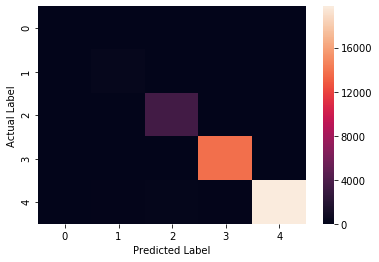

In [99]:
sns.heatmap(knn_cm2)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [100]:

# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(test_y, knn_clf2.predict( test_x )))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     20162
           1       0.99      1.00      0.99     13861
           2       0.95      1.00      0.97      3462
           3       0.73      0.97      0.83       295
           4       0.15      0.50      0.23        12

    accuracy                           0.99     37792
   macro avg       0.76      0.89      0.80     37792
weighted avg       0.99      0.99      0.99     37792



# XG Boost Model

In [101]:
#Using GridSearchCV to get best fit parameters
pm = {
          'n_estimators' : [100],
          'learning_rate': [0.1]
     }

gscv_xg2 = GridSearchCV(estimator = XGBClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

[12:43:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [102]:
#Using best fit parameters to fit the model
xg2 = gscv_xg2.best_estimator_

#Making prediction on train and test data
train_pred_xg2 = xg2.predict(train_x)
test_pred_xg2 = xg2.predict(test_x)

#Calculating log loss
log_xg2 = metrics.log_loss(test_y, xg2.predict_proba(test_x))

In [103]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_xg2))
print("AUC      : ", metrics.roc_auc_score(train_y, xg2.predict_proba(train_x), multi_class = 'ovr'))
print("")
print("Test Dataset")
acc_score_xg2 = metrics.accuracy_score(test_y, test_pred_xg2)
print("Accuracy : ", acc_score_xg2)
auc_xg2 = metrics.roc_auc_score(test_y, xg2.predict_proba(test_x), multi_class = 'ovr')
print("AUC      : ", auc_xg2)
print("Log Loss : ", log_xg2)

Model Performance
Train Dataset
Accuracy :  0.9988893834382484
AUC      :  0.9999921219534527

Test Dataset
Accuracy :  0.9963219729043183
AUC      :  0.9996640416454111
Log Loss :  0.0112018409831305


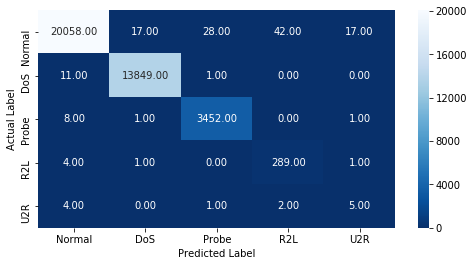

In [104]:
#Confusion Matrix
plt.figure(figsize = (8,4))
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_xg2, labels = [0,1,2,3,4])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'],
            yticklabels = ['Normal','DoS', 'Probe', 'R2L', 'U2R'],
            cmap = 'Blues_r'    
           )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [105]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_xg2))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20162
           1       1.00      1.00      1.00     13861
           2       0.99      1.00      0.99      3462
           3       0.87      0.98      0.92       295
           4       0.21      0.42      0.28        12

    accuracy                           1.00     37792
   macro avg       0.81      0.88      0.84     37792
weighted avg       1.00      1.00      1.00     37792



<BarContainer object of 12 artists>

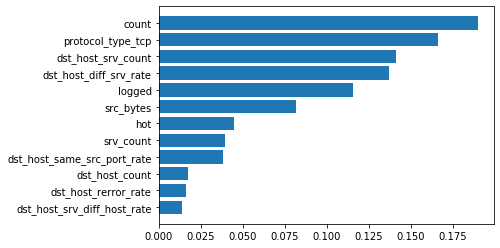

In [106]:
#Feature Impotance for Random Forest Model
xg2_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : xg2.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

xg2_fi.to_excel(output, 'Drivers_Multinomial', startrow=16, startcol=1, index = False)

plt.barh(width = xg2_fi.Importance, y = xg2_fi.Features)

### Comparing all model

In [107]:
#Getting accuracy and log loss for each model
metric_data2 = pd.DataFrame({'Classifiers' : [ 'DecisionTreeClassifier','KNNclassifier','XGBClassifier'],
                        'Accuracy %' : [acc_score_dt2,acc_score_knn_clf2,acc_score_xg2],
                        'ROC_AUC_Score %' : [ auc_dt2,auc_knn_clf2 ,auc_xg2],    
                        'Log_Loss' : [log_dt2,log_knn_clf2,log_xg2]})

In [108]:
metric_data2[['Accuracy %','ROC_AUC_Score %']] = metric_data2[['Accuracy %', 'ROC_AUC_Score %']].applymap(lambda x : round((x*100),2))

In [109]:
metric_data2.to_excel(output, 'Multinomial Metric Data')
metric_data2

,Classifiers,Accuracy %,ROC_AUC_Score %,Log_Loss
0,DecisionTreeClassifier,99.20,95.15,0.102684
1,KNNclassifier,98.66,95.50,0.095297
2,XGBClassifier,99.63,99.97,0.011202


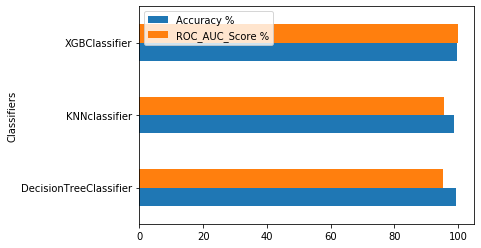

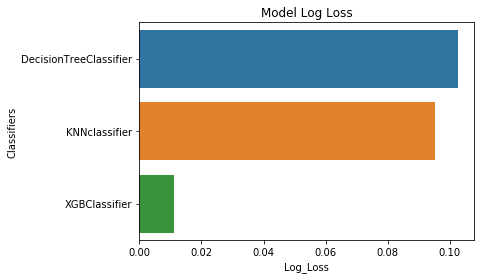

In [110]:
#Visualizing each model's accuracy and log loss metric
metric_data2.plot(x = 'Classifiers', y = ['Accuracy %','ROC_AUC_Score %'], kind = 'barh')
plt.legend(loc = 2)
plt.show()

sns.barplot(data = metric_data2, x = metric_data2['Log_Loss'], y = metric_data2.Classifiers)
plt.title('Model Log Loss')
plt.show()

## Final Prediction

In [111]:
#Making final predictions on provided test dataset
test_final2 = test[X]
test_final2['attack_class'] = test['attack_class']
test_final2['dt_attack_class'] = dt2.predict(test_final2[X])
test_final2['Knn_attack_class'] = knn_clf2.predict(test_final2[X])
test_final2['xg_attack_class'] = xg2.predict(test_final2[X])


test_final2.to_excel(output, 'Final Predictions2')

#Final Predictions
test_final2.head()

,dst_host_srv_diff_host_rate,src_bytes,dst_host_count,dst_host_same_src_port_rate,dst_host_diff_srv_rate,count,hot,protocol_type_tcp,srv_count,dst_host_rerror_rate,dst_host_srv_count,logged,attack_class,dt_attack_class,Knn_attack_class,xg_attack_class
0,-0.320917,-0.167729,0.734343,-0.480197,-0.121485,1.265346,-0.140747,1,-0.245774,2.874410,-0.954389,0,1,1,1,1
1,-0.320917,-0.167729,0.734343,-0.480197,-0.121485,0.453176,-0.140747,1,-0.371789,2.874410,-1.035688,0,1,1,1,1
2,-0.104438,1.947498,-0.485344,1.493939,-0.227350,-0.725780,-0.140747,1,-0.371789,-0.387635,-0.267863,0,0,0,0,0
3,2.709796,-0.164470,-1.805832,2.756092,-0.439078,-0.725780,-0.140747,0,0.524319,-0.387635,-0.529827,0,2,2,2,2
4,-0.104438,-0.167729,-1.543751,-0.383108,0.460769,-0.725780,-0.140747,1,-0.273777,2.319862,-0.267863,0,2,2,0,0


In [112]:
#Accuracy of prediction on provided test dataset
test_acc_dt2 = metrics.accuracy_score(test_final2['attack_class'], test_final2['dt_attack_class'])
test_acc_knn2 = metrics.accuracy_score(test_final2['attack_class'], test_final2['Knn_attack_class'])
test_acc_xg2 = metrics.accuracy_score(test_final2['attack_class'], test_final2['xg_attack_class'])


test_auc_dt2 = metrics.roc_auc_score(test_final2['attack_class'], dt2.predict_proba(test_final2[X]),multi_class = 'ovr')
test_auc_knn2 = metrics.roc_auc_score(test_final2['attack_class'],knn_clf2.predict_proba(test_final2[X]),multi_class = 'ovr')
test_auc_xg2 = metrics.roc_auc_score(test_final2['attack_class'], xg2.predict_proba(test_final2[X]),multi_class = 'ovr')


test_metric2 = pd.DataFrame({'Classifiers' : [ 'DecisionTreeClassifier','KNNclassifier' ,'XGBClassifier' ],
                        'Accuracy %' : [test_acc_dt2,test_acc_knn2, test_acc_xg2 ],
                        'ROC_AUC_Score %' : [test_auc_dt2,test_auc_xg2 , test_auc_xg2],    
                        })

In [113]:
test_metric2[['Accuracy %','ROC_AUC_Score %']] = test_metric2[['Accuracy %', 'ROC_AUC_Score %']].applymap(lambda x : round((x*100),2))
test_metric2

,Classifiers,Accuracy %,ROC_AUC_Score %
0,DecisionTreeClassifier,75.70,71.76
1,KNNclassifier,74.84,92.21
2,XGBClassifier,75.06,92.21


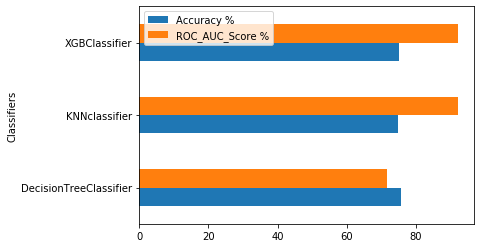

In [114]:
test_metric2.plot(x = 'Classifiers', y = ['Accuracy %','ROC_AUC_Score %'], kind = 'barh')
plt.legend(loc = 2)
plt.show()

In [115]:
output.save

<bound method _XlsxWriter.save of <pandas.io.excel._XlsxWriter object at 0x7fb93020fc88>>